In [ ]:
!pip install plotly --upgrade --user --quiet

In [1]:
import pprint
import numpy as np
import pandas as pd
import seaborn as sn
import plotly.express as px
import matplotlib.pyplot as plt
from apafib import load_BCN_IBEX
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from yellowbrick.regressor import AlphaSelection, prediction_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
RANDOM_STATE = 1

# Auxiliar Functions

In [3]:
def plot_data_frame_histogram (df):
    fig, axes = plt.subplots(8, 2, figsize=(15,30))

    # We will not plot country because it has too many categories.
    for i, c in enumerate(df.columns):
        ax = axes.reshape(-1)[i]
        c_ = c
        if len(c) > 50:
            count = 50
            while count < len(c) and c[count] != " ":
                count += 1
            if count != len(c):
                c_ = (c[:count] + "\n" + c[count:])
        if df[c].dtype.kind == 'O':
            a = sn.countplot(x=c,data=df,ax=ax)
        else:
            b = sn.histplot(x=c,data=df,ax=ax)
        ax.set_title(c_)
    plt.tight_layout()

In [4]:
def generate_matplotlib_histogram(X, labelX, labelY, title, rangeX=None, rangeY=None, bins=30):
  if rangeX is None: 
    rangeX = [np.min(X), np.max(X)]
  plt.hist(X, bins=bins, alpha=1, range=rangeX, density=True, stacked=True)  
  plt.xlabel(labelX)
  plt.ylabel(labelY)
  plt.title(title)
  if rangeY is not None:
    plt.ylim((rangeY[0], rangeY[1]))
  plt.legend([len(x) for x in X] if len(X) > 1 else "X")
  plt.show()

In [5]:
def generate_matplotlib_bar(labels, values):
    plt.barh(labels, values)
    plt.show()

In [6]:
def generate_correlation_y (correlation_matrix):
    ibex_correlation = correlation_matrix.iloc[:, 14]
    ibex_correlation = ibex_correlation.sort_values()
    ibex_keys = np.array(ibex_correlation.keys())[:-1]
    ibex_values = np.array(ibex_correlation.values)[:-1]
    generate_matplotlib_bar(ibex_keys, ibex_values)

In [7]:
def train_test_split_x_y (df, divide_xy=True):
    df_test, df_train = train_test_split(df, train_size=80, random_state=RANDOM_STATE)
    if not divide_xy:
        return df_train, df_test
    x_train, y_train  = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    x_test, y_test    = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return x_train, y_train, x_test, y_test

In [8]:
def linear_regression_fit ( model, x_train, y_train, x_test, y_test, show_predicted_error=True ):
    model.fit(x_train, y_train)
    params = model.get_params()
    score = model.score(x_test, y_test.squeeze())
    coef = model.coef_
    if show_predicted_error:
        plt.figure(figsize=(5,5))
        prediction_error(model, x_test, y_test.squeeze(), is_fitted=True)
        plt.show()
    return score, coef, params

# Data Gathering

In [9]:
df = load_BCN_IBEX()
df.head(5)

,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
0,115.0,0.0,8.01,5.61,1.3315,1.1320,1.3569,1.2932,0.5,3.0,82.0,64.0,42.510000,0.0,8079.0
1,115.0,0.0,5.96,6.51,1.5194,1.3092,1.5811,1.3750,0.5,3.0,106.0,87.0,48.720417,0.0,8079.0
2,115.0,0.0,5.31,5.52,1.3979,1.1893,1.4745,1.3311,0.5,2.0,138.0,134.0,46.927500,0.0,8079.0
3,115.0,0.0,5.72,5.13,1.8664,1.2005,1.9598,1.5096,0.5,3.0,149.0,114.0,59.849583,21.0,8079.0
4,115.0,0.0,5.23,4.25,1.8802,1.2213,1.9231,1.4455,0.5,1.0,103.0,81.0,67.545417,54.0,8062.9


In [10]:
df_standarized = df.copy()
df_standarized = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.keys())
df_standarized.head(5)

,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
0,-1.455107,-0.229182,-1.522881,0.562621,-2.364878,-1.612298,-2.325247,-1.652372,-1.28675,-0.772855,-1.190706,-1.183376,-0.959295,-1.523200,-1.729147
1,-1.455107,-0.229182,-1.863091,1.076156,-1.531872,1.287701,-1.436345,-1.140823,-1.28675,-0.772855,-0.874148,-1.013026,-0.873470,-1.523200,-1.729147
2,-1.455107,-0.229182,-1.970963,0.511268,-2.070511,-0.674544,-1.858990,-1.415358,-1.28675,-1.008718,-0.452071,-0.664921,-0.898247,-1.523200,-1.729147
3,-1.455107,-0.229182,-1.902921,0.288736,0.006464,-0.491249,0.065115,-0.299079,-1.28675,-0.772855,-0.306982,-0.813051,-0.719669,-0.982900,-1.729147
4,-1.455107,-0.229182,-1.984239,-0.213386,0.067643,-0.150842,-0.080393,-0.699939,-1.28675,-1.244581,-0.913718,-1.057465,-0.613316,-0.133859,-1.775540


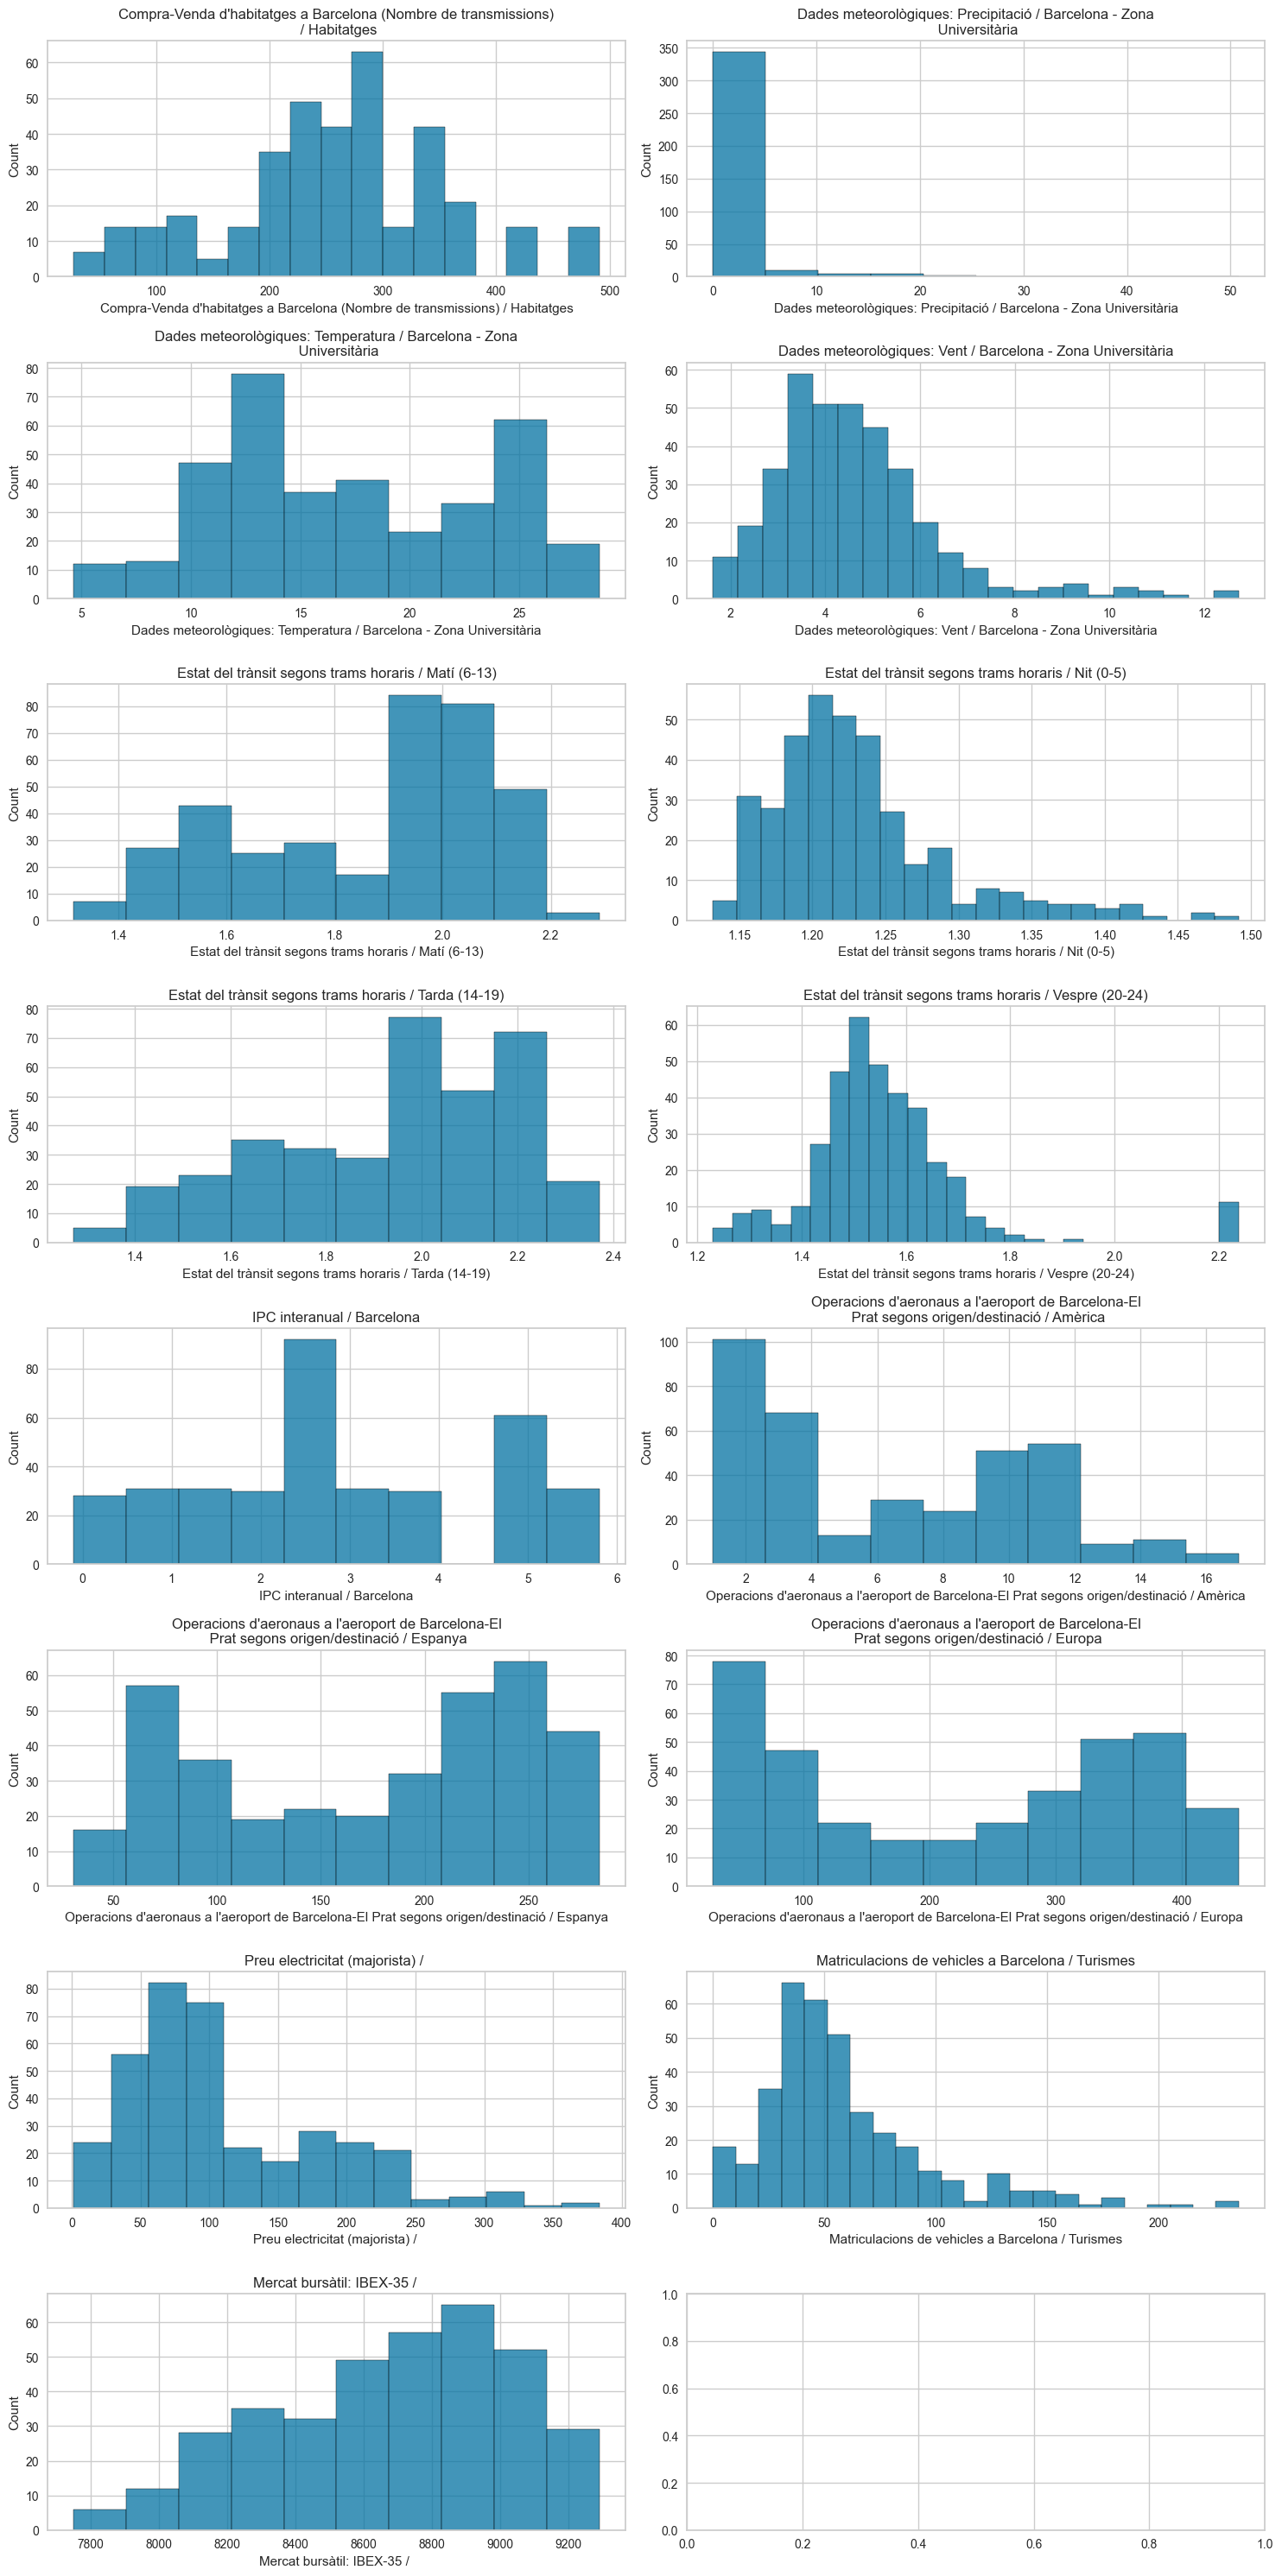

In [11]:
plot_data_frame_histogram(df)

<AxesSubplot:>

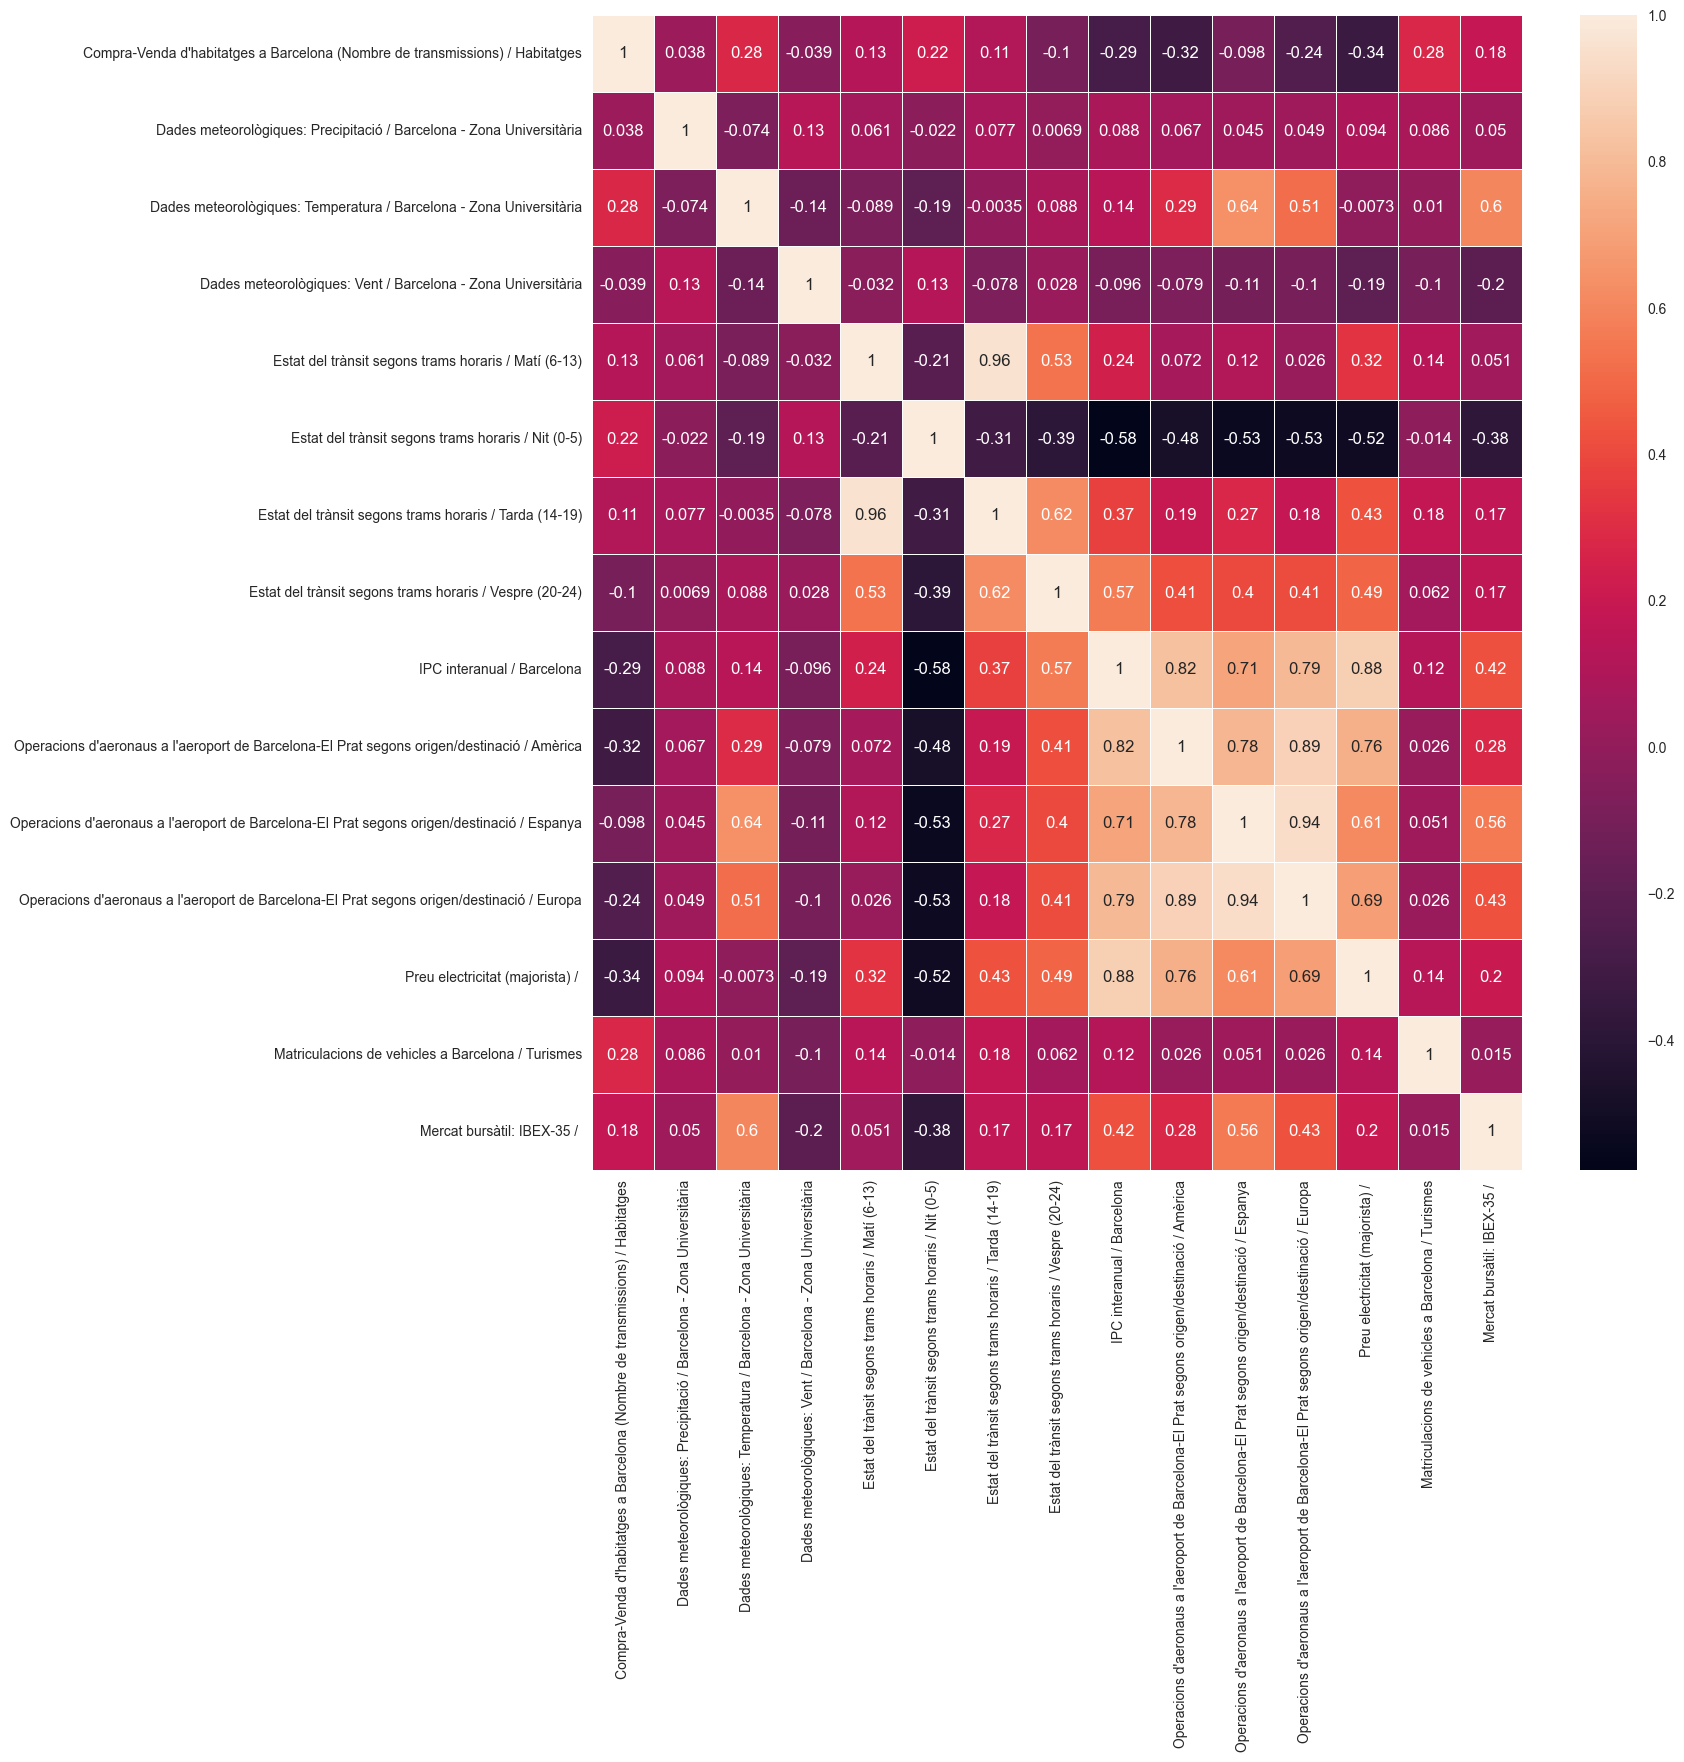

In [12]:
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(correlation_matrix, annot=True, linewidths=.5, ax=ax)

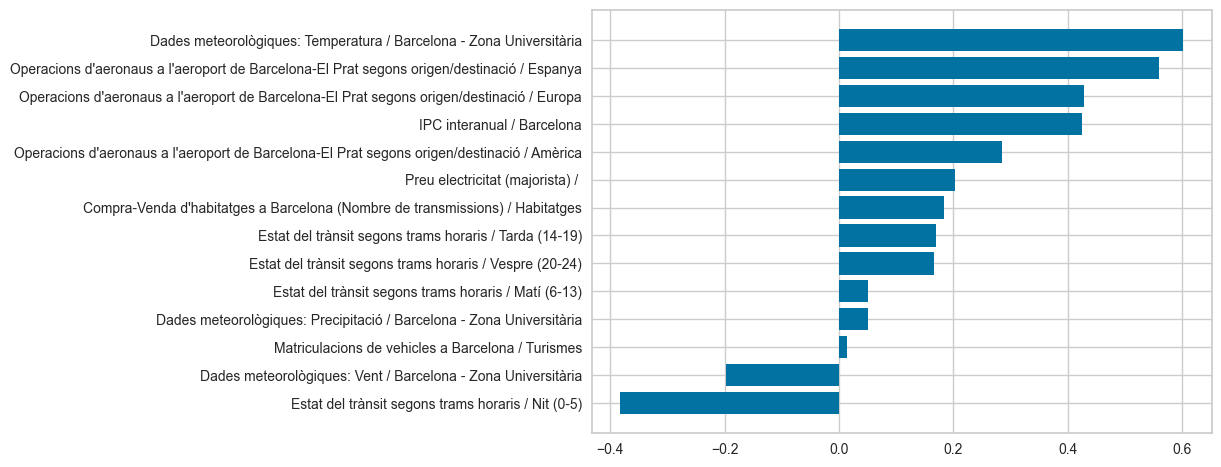

In [13]:
generate_correlation_y(correlation_matrix)

In [14]:
x_train, y_train, x_test, y_test = train_test_split_x_y(df)
train_standarized, test_standarized = train_test_split_x_y(df_standarized, divide_xy=False)
x_train_standarized, y_train_standarized, x_test_standarized, y_test_standarized = train_test_split_x_y(df_standarized)

# Apartat b. Analisis de Componentes Principales

In [15]:
myPCA = PCA().fit(x_train_standarized);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.37150392 0.1614934  0.11646189 0.09222743 0.07970808 0.05481516
 0.03709977 0.03091698 0.02736258 0.010935   0.00788017 0.00633587
 0.00182568 0.00143408]
[0.37150392 0.53299732 0.6494592  0.74168664 0.82139472 0.87620987
 0.91330965 0.94422663 0.9715892  0.9825242  0.99040437 0.99674025
 0.99856592 1.        ]


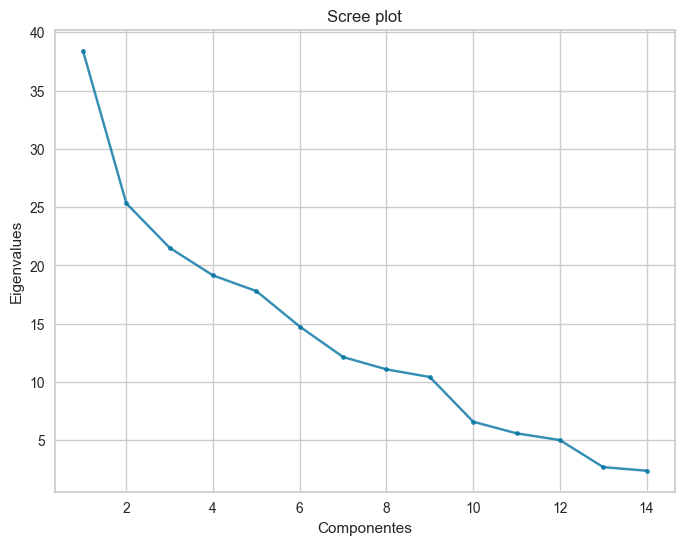

In [16]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

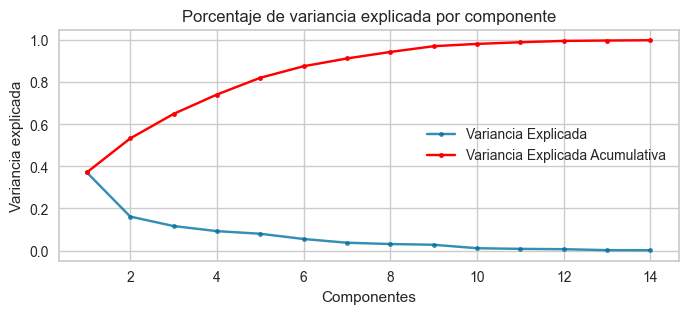

In [17]:
fig = plt.figure(figsize=(8,3));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia Explicada Acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

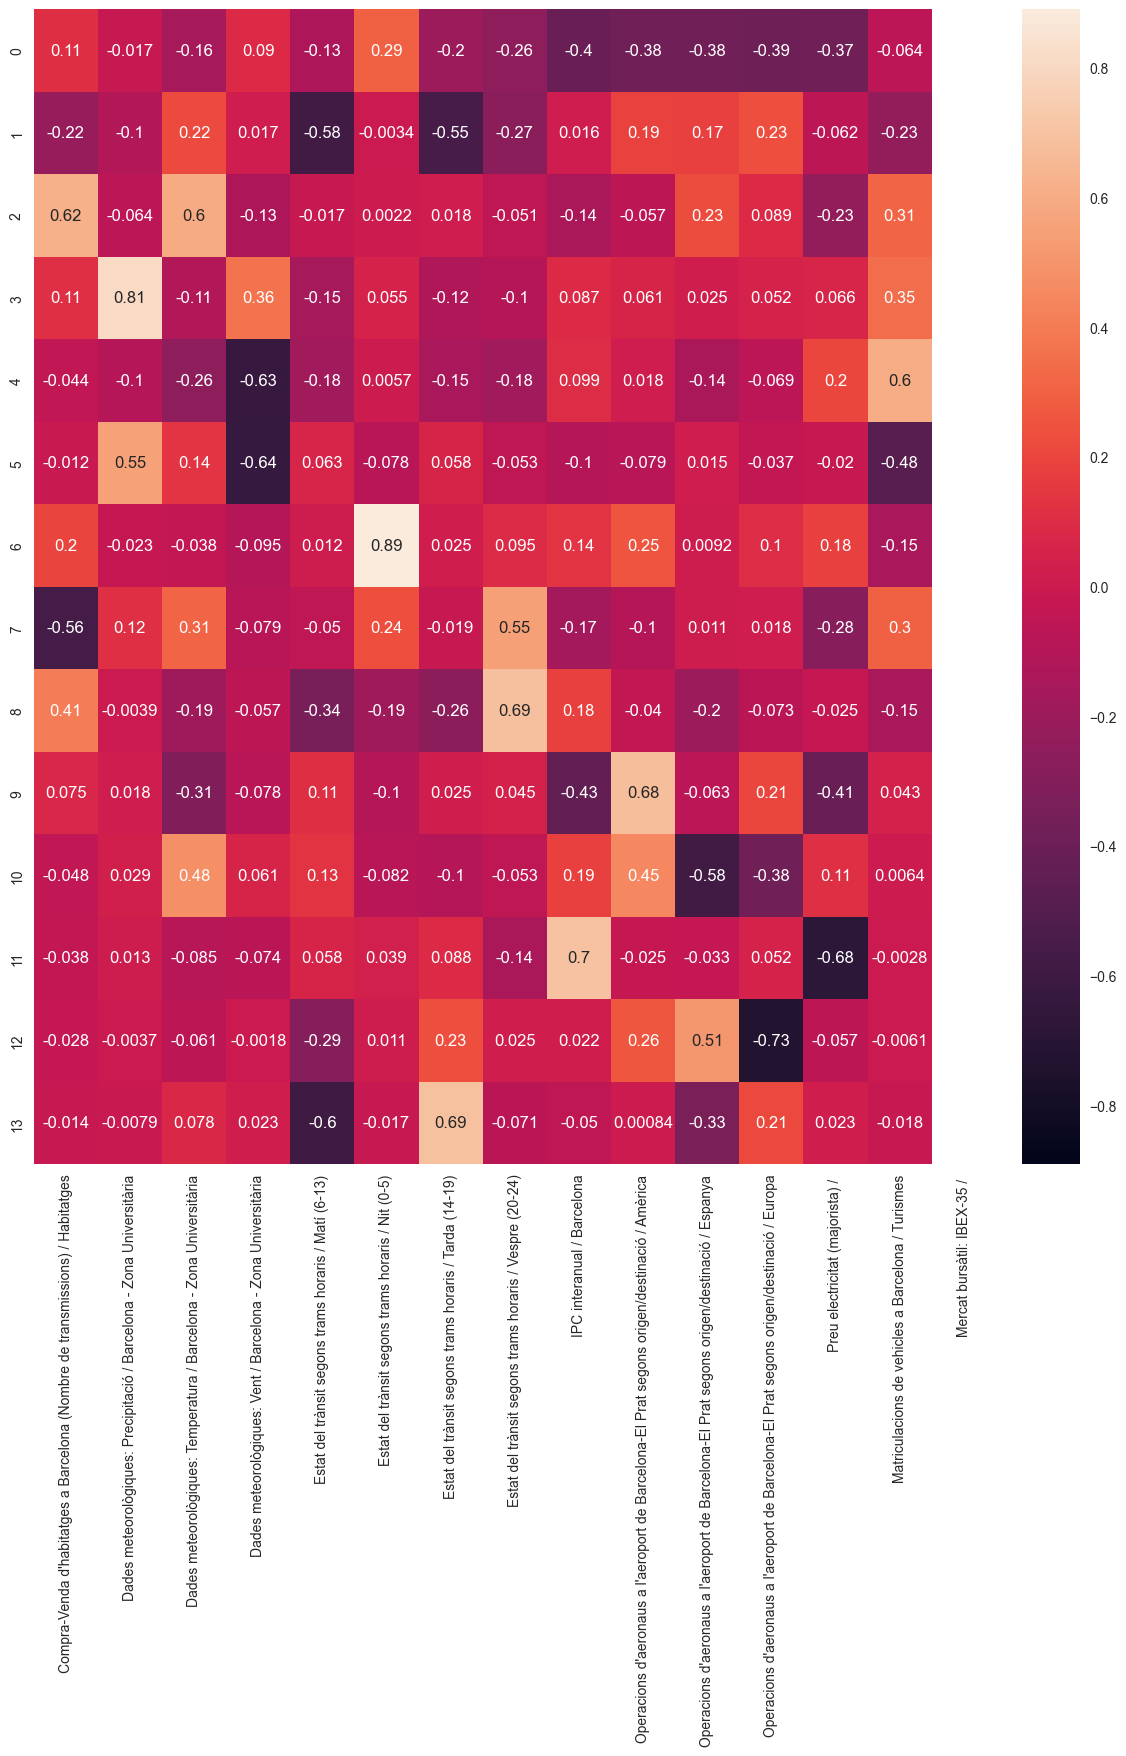

In [18]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(myPCA.components_,  
            xticklabels=list(df_standarized.columns),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

In [19]:
transformed_crabs = myPCA.transform(x_train_standarized[x_train_standarized.columns])
x_train_standarized[['PC1','PC2', 'PC3']] = transformed_crabs[:,:3]

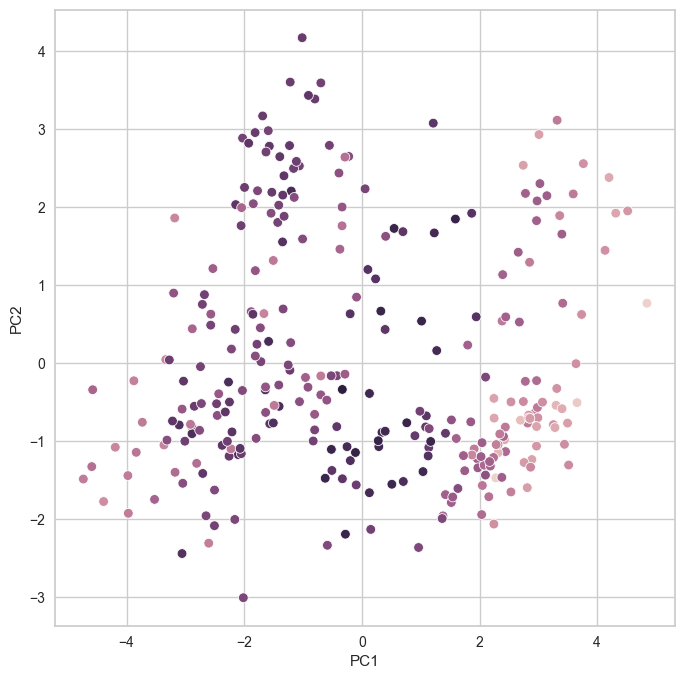

In [20]:
fig = plt.figure(figsize=(8,8))
_ = sn.scatterplot(x='PC1', y='PC2', hue=y_train ,data=x_train_standarized, legend=False)

In [21]:
fig = px.scatter_3d(x_train_standarized, x='PC1', y='PC2', z='PC3',
              color=y_train)
fig.show()

# Apartado c. Ajusta una regresion lineal

In [22]:
x_train_standarized, y_train_standarized, x_test_standarized, y_test_standarized = train_test_split_x_y(df_standarized)

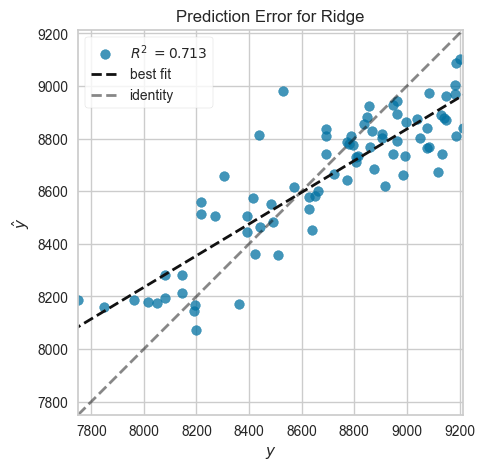

In [23]:
model_ridge = Ridge()
ridge_score, ridge_coef, ridge_params = linear_regression_fit(model_ridge, x_train_standarized, y_train, x_test_standarized, y_test)

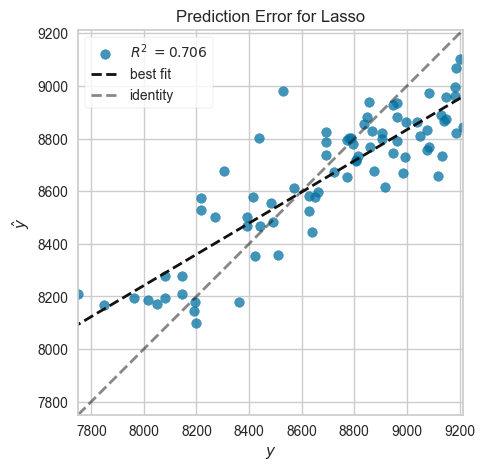

In [24]:
model_lasso = Lasso()
lasso_score, lasso_coef, lasso_params = linear_regression_fit(model_lasso, x_train_standarized, y_train, x_test_standarized, y_test)

In [25]:
x_train_standarized_clean = x_train_standarized.iloc[:, [0,1,2,6,8,10]]
x_test_standarized_clean = x_test_standarized.iloc[:, [0,1,2,6,8,10]]

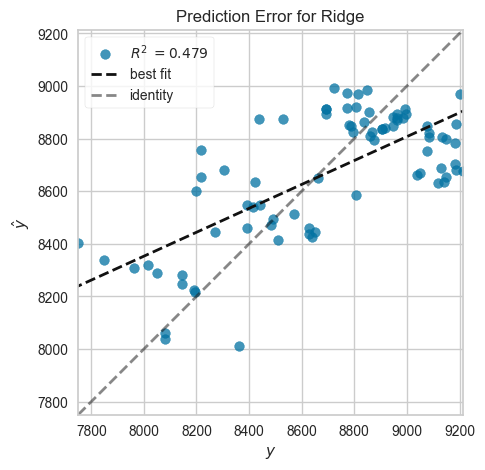

In [26]:
model_ridge_clean = Ridge()
ridge_score_clean, ridge_coef_clean, ridge_params_clean = linear_regression_fit(model_ridge_clean, x_train_standarized_clean, y_train, x_test_standarized_clean, y_test)

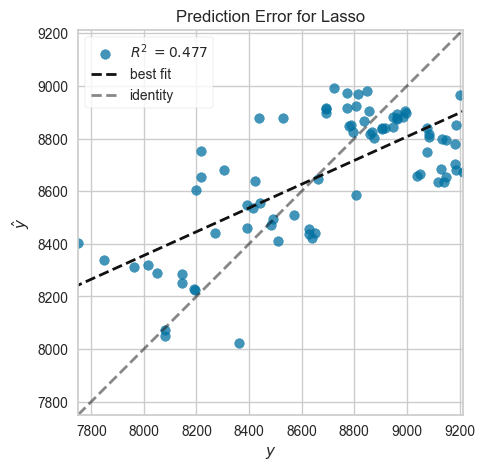

In [27]:
model_lasso_clean = Lasso()
lasso_score_clean, lasso_coef_clean, lasso_params_clean = linear_regression_fit(model_lasso_clean, x_train_standarized_clean, y_train, x_test_standarized_clean, y_test)

## Apartado d. Uso de PolynomialFeatures

In [28]:
poly = PolynomialFeatures(2)
x_train_standarized_poly = poly.fit_transform(x_train_standarized)
x_test_standarized_poly = poly.fit_transform(x_test_standarized)
len(x_train_standarized.to_numpy()[0]), len(x_train_standarized_poly[0])

(14, 120)

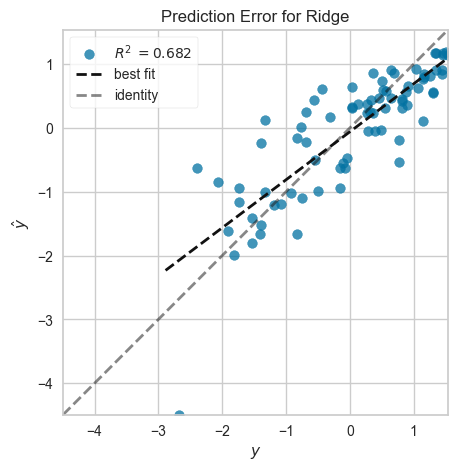

In [29]:
model_ridge_poly = Ridge()
ridge_score_poly, ridge_coef_poly, ridge_params_poly = linear_regression_fit(model_ridge_poly, x_train_standarized_poly, y_train_standarized, x_test_standarized_poly, y_test_standarized)

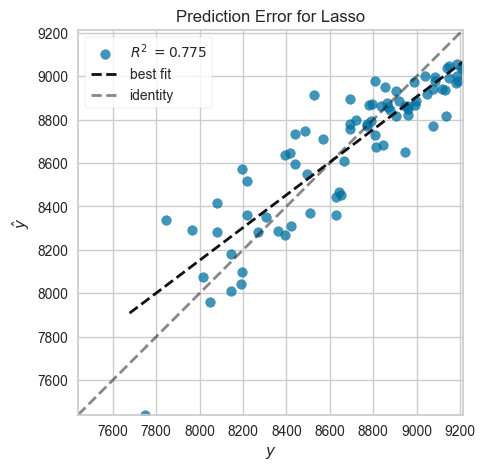

In [30]:
model_lasso_poly = Lasso()
lasso_score_poly, lasso_coef_poly, lasso_params_poly = linear_regression_fit(model_lasso_poly, x_train_standarized_poly, y_train, x_test_standarized_poly, y_test)